In [1]:
%matplotlib inline
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import matplotlib as mpl


import numpy as np
import pandas as pd
from activ import TrackTBIFile
from activ.viz import get_nmf_colors, get_nmf_labels, get_embeddings, get_nmf_feature_types
from activ.nmf.viz import weights_pie_scatter
# from activ.cca.viz import cross_decomp_scatter
import matplotlib.colors as mpc
from activ.paper import plot_cat2cont

/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: 

1. Conceptual figure for CCA
2. Cumulative outcome variance explained as a function of sorted CVs
3. Scatter plots for first CV
4. scatter plot for second CV
5. Horizontal barplots. Mirror current orientations across vertical axis
6. Heatmap


In [2]:
CONCEPTUAL_PATH = "../../paper/cross-decomposition-paper.png"
ALL_CVS_PATH = "final_ccas/tracktbi.cca.all_cvs.sparse.h5"
NMFS_PATH = "../NMF/tracktbi.reg_nmf.h5"

# Conceptual Figure

In [3]:
def add_border(img, size=10):
    sh = img.shape
    new_sh = (sh[0] + 2*size, sh[1] + 2*size, sh[2])
    ret = np.zeros(new_sh)
    ret[size:-size, size:-size, :] = img
    return ret

def display_img(path, ax=None, border=10):
    if ax is None:
        ax = plt.gca()
    img = plt.imread(path)
    if border is not None:
        img = add_border(img, size=10)
    ax.imshow(img)
    ax.axis('off')

# Cumulative Explained Variance

In [4]:
from activ.cca.utils import compute_explained_variance

def get_exp_var(path):
    tbifile = TrackTBIFile(path)
    cv_bm = tbifile.cca.bm
    cv_oc = tbifile.cca.oc
    exp_var, n_comp = compute_explained_variance(cv_bm, cv_oc, tbifile.outcomes, perc_var=1.0, method='cos')
    return exp_var

def plot_exp_var(exp_var, ylabel=None, ax=None, fontsize=24, color='black', n_cvs=None):
    if ax is None:
        ax = plt.gca()
    if isinstance(exp_var, str):
        exp_var = get_exp_var(path)
    exp_var = np.sort(exp_var)[::-1]
    ax.plot(exp_var, color=color)
    ax.set_xlabel('Canonical variate', fontsize=fontsize)
    #ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params('both', labelsize=fontsize)
    if n_cvs is not None:
        ax.axvline(n_cvs, color='red', ls='--')
    
def plot_cum_exp_var(exp_var, ylabel=None, ax=None, fontsize=24, color='black', n_cvs=None):
    if ax is None:
        ax = plt.gca()
    if isinstance(exp_var, str):
        exp_var = get_exp_var(path)
    cum = np.sort(exp_var)[::-1].cumsum()
    ax.plot(cum, color=color)
    ax.set_xlabel('Canonical variate', fontsize=fontsize)
    #ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params('both', labelsize=fontsize)
    #ax.axhline(0.95, ls=':', color='k')
    ytick = [0.0, 0.9]
    ax.set_yticks(ytick)
    ax.set_yticklabels(ytick)
    if n_cvs is not None:
        ax.axvline(n_cvs, color='red', ls='--')

In [5]:
exp_var = get_exp_var(ALL_CVS_PATH)

# Weights Heatmap

In [6]:
def weights_heatmap_helper(weights, label, ax=None, fontsize=24, cbar=False, cv_order=None):
    mat = weights.T
    if cv_order is None:
        cv_order = np.argsort(np.max(np.asarray(mat), axis=1))[::-1]
    mat = mat[cv_order]
    to_sort = list()
    for i, c in enumerate(mat.T):
        val = 0.0
        if np.abs(c).sum() < 0.15:
            mi = mat.shape[1]
            continue
        else:
            mi = np.argmax(np.abs(c))
            val = -1*c[mi]
        to_sort.append((mi, val, i))
    to_sort = sorted(to_sort)
    feat_order = np.array([t[2] for t in to_sort])
    mat = mat[:, feat_order]

    vmax = np.abs(mat).max()
    vmin = -1 * vmax

    if ax is None: ax = plt.gca()

    im = ax.imshow(mat, aspect='auto', interpolation='none', cmap='RdGy', vmin=vmin, vmax=vmax)

    if cbar:
        cbar_ax = ax.figure.colorbar(im, ax=ax).ax
        cbar_ax.tick_params('y', labelsize=12)

    ax.tick_params('both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax.set_ylabel('Canonical variate', fontsize=fontsize)
    ax.set_xlabel(label, fontsize=fontsize)
    return cv_order
    
def weights_heatmap(path, ax_bm, ax_oc, n_cvs=None, fontsize=24):    
    tbifile = TrackTBIFile(path)
    bm_weights = tbifile.cca.bm_bases
    oc_weights = tbifile.cca.oc_bases
    if isinstance(n_cvs, int):
        bm_weights = bm_weights[:, :n_cvs]
        oc_weights = oc_weights[:, :n_cvs]
    elif isinstance(n_cvs, (np.ndarray, list)):
        bm_weights = bm_weights[:, n_cvs]
        oc_weights = oc_weights[:, n_cvs]
    cv_order = weights_heatmap_helper(oc_weights, 'Outcomes', ax=ax_oc, fontsize=fontsize)
    weights_heatmap_helper(bm_weights, 'Clinical features', ax=ax_bm, fontsize=fontsize, cv_order=cv_order)
    return cv_order

# Barplots

In [7]:
from activ.viz import get_nmf_colors, get_nmf_labels, get_embeddings, get_nmf_feature_types

def add_loadings(dd_df, loadings):
    """
    Args:
        dd_df (pd.DataFrame)    : DataFrame of the variable class
        loadings (array)        : shape = (n_features, n_cvs)
    """
    dd_df = dd_df.copy()
    for i in range(loadings.shape[1]):
        dd_df[str(i+1)] = loadings[:, i]
    return dd_df


def get_key(labels):
    def key(x):
        return pd.Series(index=labels, data=np.arange(len(labels))).filter(x).values
    return key


def get_domain_weight(df, ddict, coef, domain=True, subdomain=True, scale=False):
    """

    Args:
        scale: scale weights by the number of variables in the domain
    """
    weights = np.abs(coef[coef != 0])
    weights /= weights.sum()
    sub_data_dict = ddict.filter(items=df.columns[coef != 0], axis=0)
    dweight = dict()
    for d in np.unique(sub_data_dict):
        mask = (sub_data_dict == d).values.flatten()
        if scale:
            dweight[d] = weights[mask].mean()
        else:
            dweight[d] = weights[mask].sum()
    s = pd.Series(data = dweight)
    s /= s.sum()
    return s

In [8]:
def get_barplot_dfs(cca_path, nmf_path, n_cvs=None):
    tbifile = TrackTBIFile(cca_path)
    gcs_simple = tbifile.biomarkers[:, np.where(tbifile.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
    
    bm_cv = tbifile.cca.bm
    oc_cv = tbifile.cca.oc
    
    bm_loadings = tbifile.cca.bm_bases
    oc_loadings = tbifile.cca.oc_bases
    
    if isinstance(n_cvs, int):
        bm_cv = bm_cv[:, :n_cvs]
        oc_cv = oc_cv[:, :n_cvs]
        bm_loadings = bm_loadings[:, :n_cvs]
        oc_loadings = oc_loadings[:, :n_cvs]
    elif isinstance(n_cvs, (np.ndarray, list)):
        bm_cv = bm_cv[:, n_cvs]
        oc_cv = oc_cv[:, n_cvs]
        bm_loadings = bm_loadings[:, n_cvs]
        oc_loadings = oc_loadings[:, n_cvs]
        
    nmf_tbifile = TrackTBIFile(nmf_path)
    datadict_df = get_nmf_feature_types(nmf_tbifile)
    
    bm_df = nmf_tbifile.biomarker_df()
    oc_df = nmf_tbifile.outcome_df()

    x_dweights = list()
    y_dweights = list()
    scale = True
    for i in range(oc_loadings.shape[1]):
        x_dweight = get_domain_weight(bm_df, datadict_df, bm_loadings[:, i], scale=scale)
        y_dweight = get_domain_weight(oc_df, datadict_df, oc_loadings[:, i], scale=scale)
        x_dweight.name = '' #'CV-%d predictors' % (i+1)
        y_dweight.name = '' #'CV-%d outcomes' % (i+1)
        x_dweights.append(x_dweight.to_dict())
        y_dweights.append(y_dweight.to_dict())
    x_dweights = pd.DataFrame(data=x_dweights).fillna(0)
    y_dweights = pd.DataFrame(data=y_dweights).fillna(0)
    
    return x_dweights, y_dweights


def make_sorted_barplot(df, labels, colors, ax=None):
    if ax is None:
        ax = plt.gca()

    x = df.values

    labels = np.asarray(labels)
    colors = np.asarray(colors)

    order = [np.where(labels == v)[0][0] for v in df.columns]


    colors = colors[order]
    labels = labels[order]

    w = 2
    n_cvs, n_grps = x.shape
    left = np.arange(n_cvs)*(n_grps+1)*2
    grp_order = np.argsort(x)[:, ::-1]
    
    xpos = ((np.array([np.where(grp_order == i)[1] for i in np.arange(n_grps)])* w) + left).T

    for i in range(n_grps):
        ax.barh(xpos[:, i], x[:, i], w, color=colors[i], label=labels[i])


def plot_grouped_barplot(cca_path, nmf_path, ax_bm=None, ax_oc=None, fontsize=24, n_cvs=None):    
    if ax_bm is None or ax_oc is None:
        fig, (ax_bm, ax_oc) = plt.subplots(1, 2, figsize=(10, 5))

    bm_bases_labels, oc_bases_labels = get_nmf_labels()
    bm_colors, oc_colors = get_nmf_colors()
    x_dweights, y_dweights = get_barplot_dfs(cca_path, nmf_path, n_cvs=n_cvs)

    make_sorted_barplot(x_dweights, bm_bases_labels, bm_colors, ax=ax_bm)
    make_sorted_barplot(y_dweights, oc_bases_labels, oc_colors, ax=ax_oc)

    ax = ax_bm
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.invert_xaxis()  # labels read top-to-bottom
    ax.set_yticks([])
    
    ax_oc.invert_yaxis()

    ax_oc.set_yticks([])
    ax_oc.set_yticklabels([])
    
    ax_bm.tick_params('both', labelsize=fontsize)
    ax_oc.tick_params('both', labelsize=fontsize)
    
    ticks = [0.0, 0.1, 0.2]
    for ax in (ax_bm, ax_oc):
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)

# Scatter

In [9]:
from activ.cca.viz import cross_decomp_scatter

def plot_scatters(path, axes=None, n_cvs=2, fontsize=24, **kwargs):

    if axes is None:
        fig, axes = plt.subplots(1, n_cvs, figsize=(5*n_cvs, 5))

    tbifile = TrackTBIFile(path)
    cv_bm = tbifile.cca.bm
    cv_oc = tbifile.cca.oc
    gcs_simple = tbifile.biomarkers[:, np.where(tbifile.biomarker_features == 'GCSMildModSevereRecode')[0][0]]
    
    gcs_hurd = np.zeros(len(gcs_simple), dtype='U8')
    gcs_hurd[gcs_simple == 0.0] = 'Mild'
    gcs_hurd[gcs_simple == 1.0] = 'Moderate'
    gcs_hurd[gcs_simple == 2.0] = 'Severe'
    
    for i in range(n_cvs):
        x = cv_bm[:, i]
        y = cv_oc[:, i]
        cross_decomp_scatter(x, y, fontsize=fontsize, labels=gcs_hurd, ax=axes[i], legend_fontsize=fontsize, **kwargs)

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from activ.viz import get_labels

def _check_array(v):
    if isinstance(v, pd.Series):
        v = v.values
    if len(v.shape) == 1:
        v = v.reshape(v.shape[0], 1)
    elif len(v.shape) == 2:
        if v.shape[1] != 1:
            raise ValueError('v must be 1D: shape = %s' % str(v.shape))
        v = v.reshape(v.shape[0])
    return v

def cross_decomp_scatter(x, y, regressor=LinearRegression(), labels=None, fitline=True,
                         solid_points=False, markeredgewidth=1, markersize=None,
                         fontsize=24, legend_fontsize=None,
                         title=None, xlabel=None, ylabel=None, legend_title=None, ax=None):
    """
    Args:
        x:                  the independent variable to plot
        y:                  the dependent variable to plot
        regressor:          the scikit-learn regressor object to use draw a line-fit
        labels:             category labels to apply
        solid_points:       plot solid points instead of circles
        markeredgewidth:    the edge widgth of markers
        markeredgesize:     the size of markers
        title:              the title to add to the plot
        xlabel:             the label to add to the X-axis
        ylabel:             the label to add to the Y-axis
        legend_title:       the title to give to the legend
        ax:                 the matplotlib Axes object draw the plot on
    """
    if ax is None:
        import matplotlib.pyplot as plt
        ax = plt.gca()

    _x = _check_array(x)
    _y = _check_array(y)

    colors, patches = None, None
    mk_kwargs = dict(marker='o', color='none')
    scatter_kwargs = dict()

    if solid_points:
        markersize = markersize or 5
        scatter_kwargs['c'] = colors
        colors_key = 'c'
    else:
        markersize = markersize or 9
        mk_kwargs['markerfacecolor'] = 'none'
        mk_kwargs['markeredgewidth'] = markeredgewidth or 1
        colors_key = 'edgecolors'
        scatter_kwargs['facecolors'] = 'none'
        scatter_kwargs['linewidths'] = mk_kwargs['markeredgewidth']

    mk_kwargs = dict(marker='o', color='none')
    scatter_kwargs = dict()

    if solid_points:
        markersize = markersize or 5
        scatter_kwargs['c'] = colors
        colors_key = 'c'
    else:
        markersize = markersize or 9
        mk_kwargs['markerfacecolor'] = 'none'
        mk_kwargs['markeredgewidth'] = markeredgewidth or 1
        colors_key = 'edgecolors'
        scatter_kwargs['facecolors'] = 'none'
        scatter_kwargs['linewidths'] = mk_kwargs['markeredgewidth']

    mk_kwargs['markersize'] = markersize
    scatter_kwargs['s'] = markersize**2


    if labels is not None:
        colors, patches = get_labels(labels, solid_points=solid_points, marker_kwargs=mk_kwargs)
    else:
        colors = ['black'] * _x.shape[0]

    scatter_kwargs[colors_key] = colors

    ax.scatter(_x, _y, **scatter_kwargs)

    if legend_fontsize is None:
        legend_fontsize = fontsize-4

    if patches is not None:
        ax.legend(handles=patches, title=legend_title, loc=2, fontsize=legend_fontsize)

    ax.tick_params('both', labelsize=fontsize)

    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fontsize)

    if fitline:
        y_pred = cross_val_predict(regressor, _x, _y, cv=5)
        cv_r2 = r2_score(_y, y_pred)

        regressor.fit(_x, _y)
        # raw_r2 = r2_score(_y, regressor.predict(_x))

        xfit = np.linspace(min(_x),max(_x), 1000).reshape((1000,1))
        yfit = regressor.predict(xfit)
        
        ax.plot(xfit, yfit, color='black')
        x_pos, y_pos = (0.5, 0.1)
        ax.text(x_pos, y_pos, "$R^2$ = %0.4f" % cv_r2, size=fontsize, transform=ax.transAxes)
    return ax

0.36499679226156


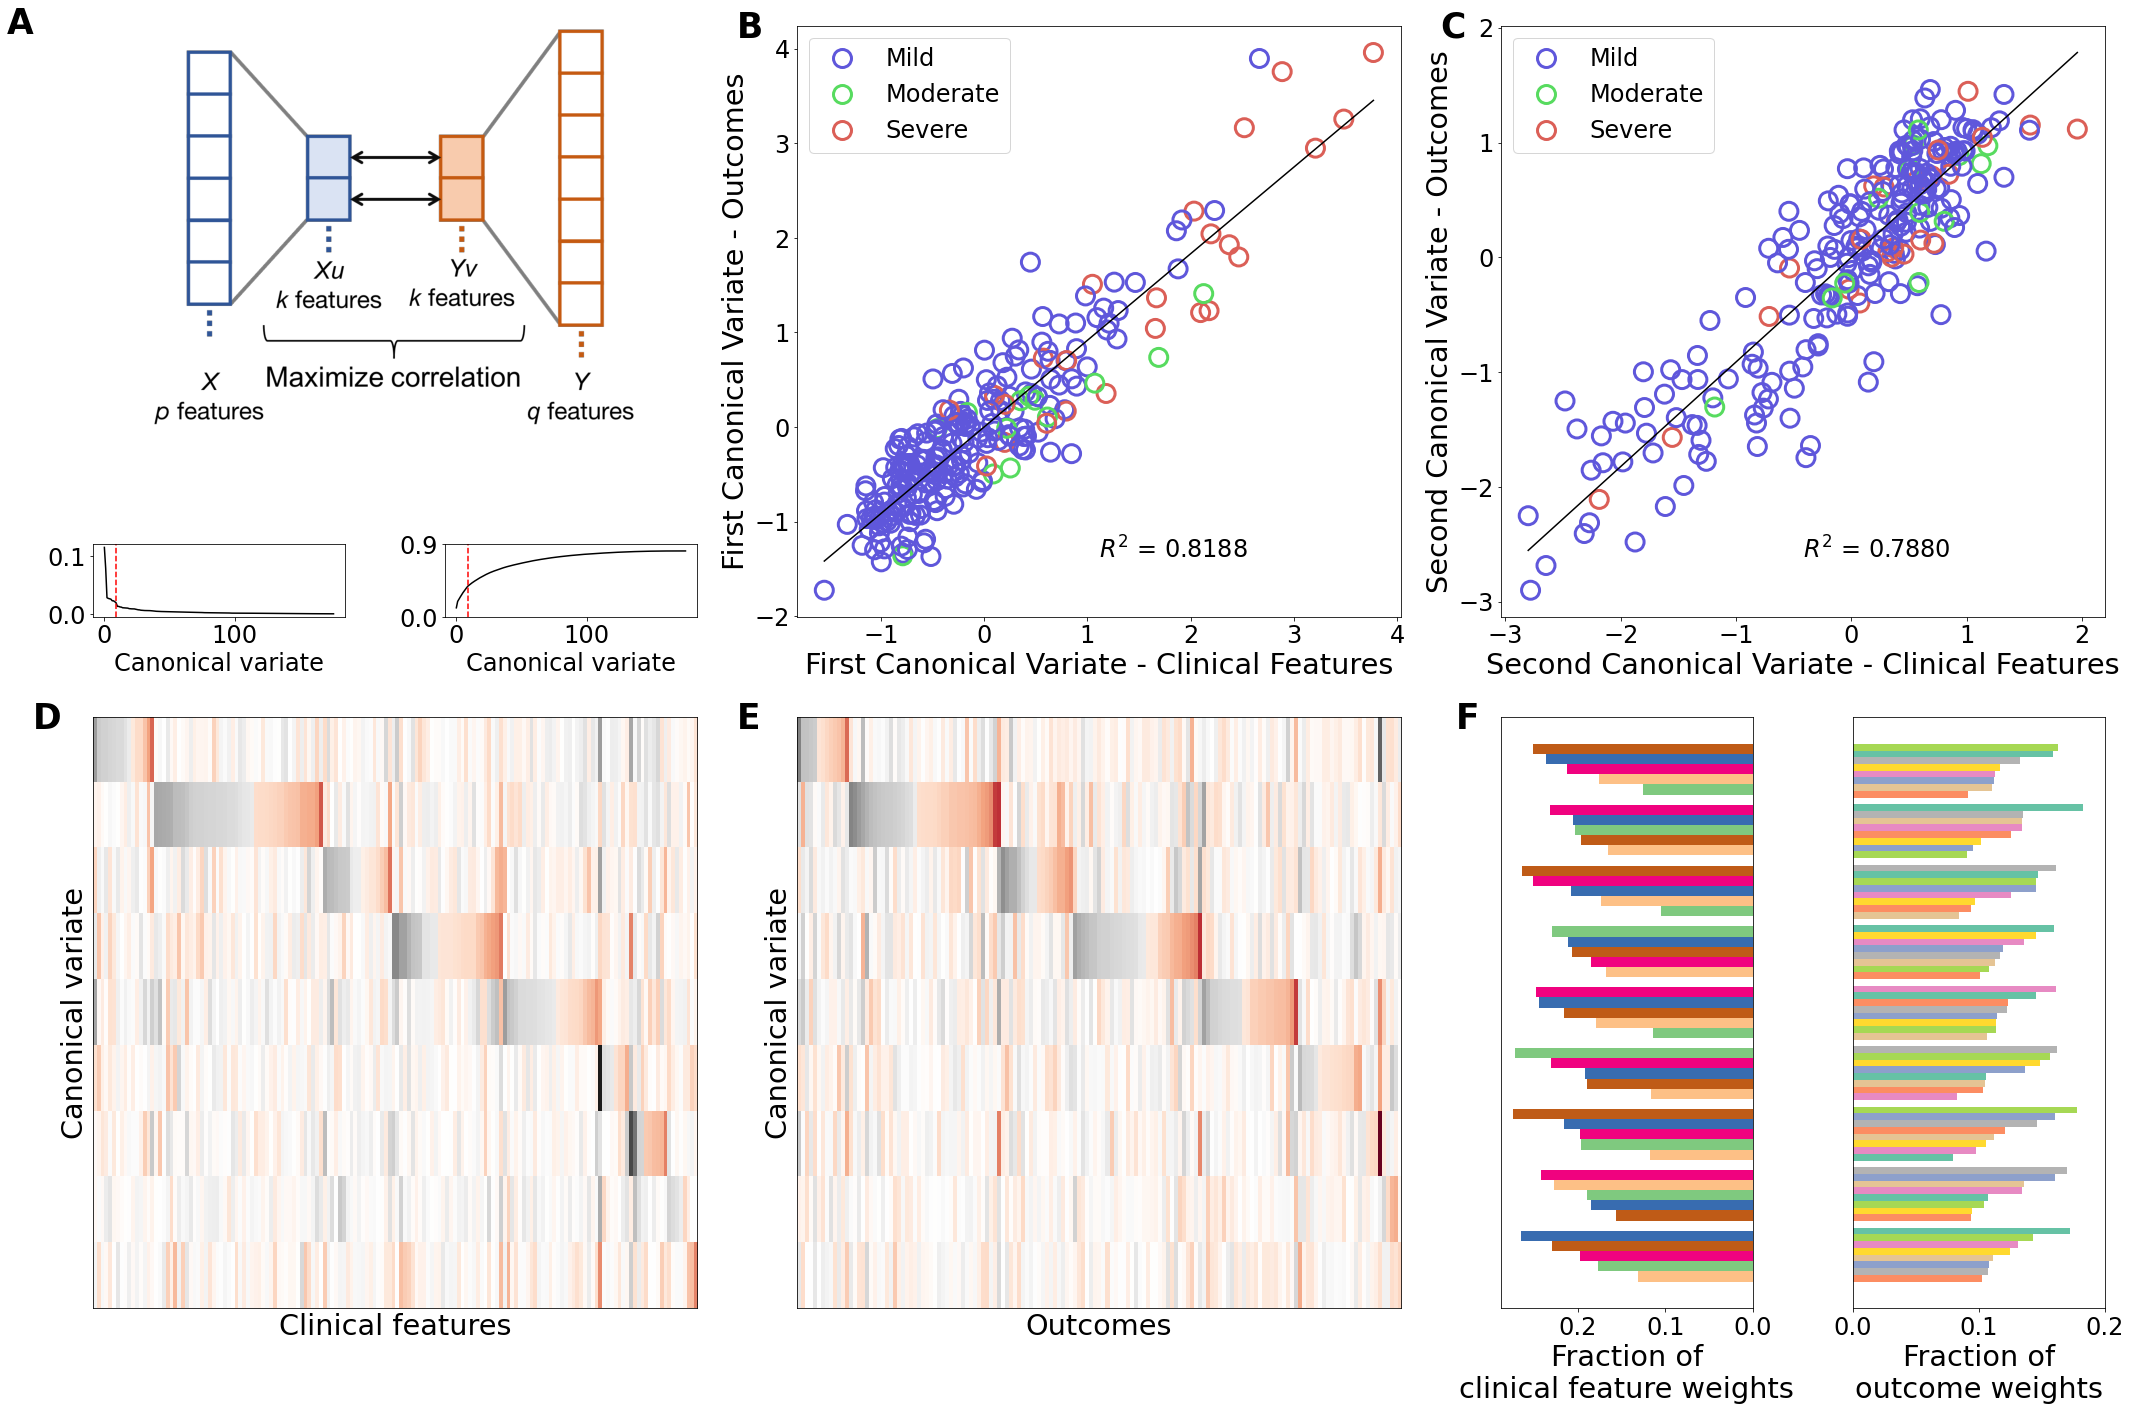

In [26]:
#fig = plt.figure(figsize=(12, 8), tight_layout=True)
fig = plt.figure(figsize=(30, 20), tight_layout=True)
mpl.rcParams['font.size'] = 20
n_cvs = 9

q_x = 1
half_x = 2*q_x
x = 2 * half_x
gs = mgrid.GridSpec(nrows=2*x, ncols=3*x)

# Conceptual figure
ax_Concept = fig.add_subplot(gs[0:3*q_x, 0:x])
display_img(CONCEPTUAL_PATH, ax_Concept, border=0)

# Cumulative Explained Varianc
ax_ExpVar = fig.add_subplot(gs[3*q_x:x, 0:half_x])
ax_CumVar = fig.add_subplot(gs[3*q_x:x, half_x:x])
plot_exp_var(exp_var, ax=ax_ExpVar, n_cvs=n_cvs)
plot_cum_exp_var(exp_var, ax=ax_CumVar, n_cvs=n_cvs)

sig_cvs = np.argsort(exp_var)[::-1][:n_cvs]

print(exp_var[sig_cvs].sum())

# Scatters
ax_Scatter = list()
ax_Scatter.append(fig.add_subplot(gs[:x, x:2*x]))
ax_Scatter.append(fig.add_subplot(gs[:x, 2*x:]))
plot_scatters(ALL_CVS_PATH, axes=ax_Scatter, markeredgewidth=3, markersize=18)

size2 = 'x-large'
ax_Scatter[0].set_xlabel("First Canonical Variate - Clinical Features", fontsize=size2)
ax_Scatter[0].set_ylabel("First Canonical Variate - Outcomes", fontsize=size2)
ax_Scatter[1].set_xlabel("Second Canonical Variate - Clinical Features", fontsize=size2)
ax_Scatter[1].set_ylabel("Second Canonical Variate - Outcomes", fontsize=size2)


# Heatmaps
ax_BMHeatmap = fig.add_subplot(gs[x:, :x])
ax_OCHeatmap = fig.add_subplot(gs[x:, x:2*x])
cv_order = weights_heatmap(ALL_CVS_PATH, ax_BMHeatmap, ax_OCHeatmap, n_cvs=sig_cvs, fontsize=size2)


# Barplots
ax_BMBars = fig.add_subplot(gs[x:, 2*x:5*half_x])
ax_OCBars = fig.add_subplot(gs[x:, 5*half_x:])
plot_grouped_barplot(ALL_CVS_PATH, NMFS_PATH, ax_bm=ax_BMBars, ax_oc=ax_OCBars, n_cvs=sig_cvs[cv_order])

ax_BMBars.set_xlabel("Fraction of\nclinical feature weights", fontsize='x-large')
ax_OCBars.set_xlabel("Fraction of\noutcome weights", fontsize='x-large')


def add_label(ax, label, x=-0.1, y=0.98 ):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='xx-large')   
    
add_label(ax_Concept, "A", x=-0.25)
add_label(ax_BMBars, "F", x=-0.18)
add_label(ax_BMHeatmap, "D")
add_label(ax_OCHeatmap, "E")
add_label(ax_Scatter[0], "B")
add_label(ax_Scatter[1], "C")    

for ax in (ax_BMBars, ax_BMHeatmap, ax_OCHeatmap, *ax_Scatter):
    ax.tick_params('both', labelsize='large')

plt.savefig('../../paper/MultiPanel_sparse_cca.png', dpi=100)

Text(0, 1, 'A')

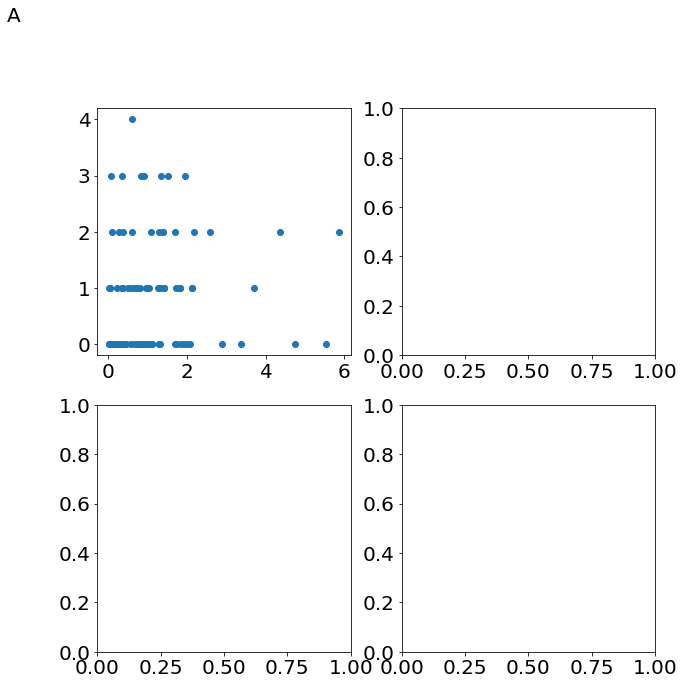

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))



ax = axes[0, 0]

axes[0, 0].scatter(np.random.exponential(size=100), np.random.poisson(size=100))

fig.text(0, 1, 'A')



In [18]:
dir(ax)
ax.get_position()

Bbox([[0.125, 0.5368181818181819], [0.47727272727272724, 0.88]])

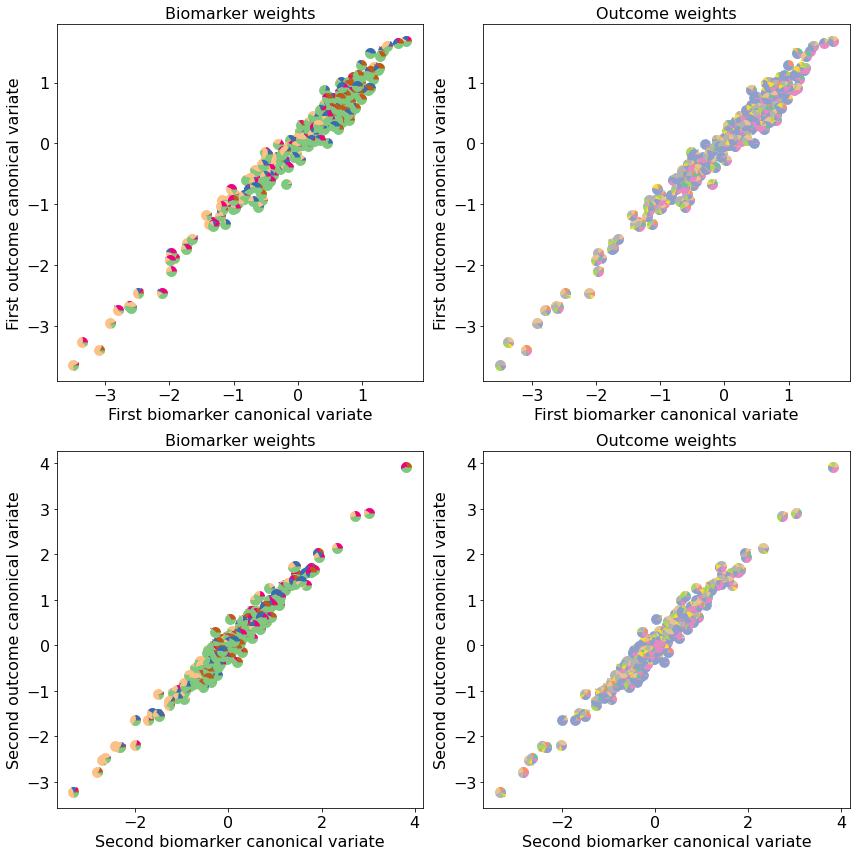

In [339]:
from activ.nmf.viz import plot_umap_nmf_piechart


nmf_tbifile = TrackTBIFile(NMFS_PATH)
bm_weights, bm_bases = nmf_tbifile.nmf.bm, nmf_tbifile.nmf.bm_bases
oc_weights, oc_bases = nmf_tbifile.nmf.oc, nmf_tbifile.nmf.oc_bases
bm_colors, oc_colors = get_nmf_colors()


tbifile = TrackTBIFile(ALL_CVS_PATH)
cv_bm = tbifile.cca.bm
cv_oc = tbifile.cca.oc

cv1 = np.array([cv_bm[:, 0], cv_oc[:, 0]]).T
cv2 = np.array([cv_bm[:, 1], cv_oc[:, 1]]).T

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

fs=16

plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), cv1, s=70, ax=axes[0, 0], fontsize=fs, palette=bm_colors)
axes[0, 0].set_title('Biomarker weights', fontsize=fs)
axes[0, 0].set_xlabel('First biomarker canonical variate')
axes[0, 0].set_ylabel('First outcome canonical variate')

plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), cv1, s=70, ax=axes[0, 1], fontsize=fs, palette=oc_colors)
axes[0, 1].set_title('Outcome weights', fontsize=fs)
axes[0, 1].set_xlabel('First biomarker canonical variate')
axes[0, 1].set_ylabel('First outcome canonical variate')


plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), cv2, s=70, ax=axes[1, 0], fontsize=fs, palette=bm_colors)
axes[1, 0].set_title('Biomarker weights', fontsize=fs)
axes[1, 0].set_xlabel('Second biomarker canonical variate')
axes[1, 0].set_ylabel('Second outcome canonical variate')

plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), cv2, s=70, ax=axes[1, 1], fontsize=fs, palette=oc_colors)
axes[1, 1].set_title('Outcome weights', fontsize=fs)
axes[1, 1].set_xlabel('Second biomarker canonical variate')
axes[1, 1].set_ylabel('Second outcome canonical variate')

plt.tight_layout()
plt.savefig('../../paper/cca_nmf_piecharts.png', dpi=100)

In [327]:
bm_colors, oc_colors = get_nmf_colors()
bm_bases_labels, oc_bases_labels = get_nmf_labels()

#for i in range(n_grps):
#    pass

x_df.shape

(9, 5)

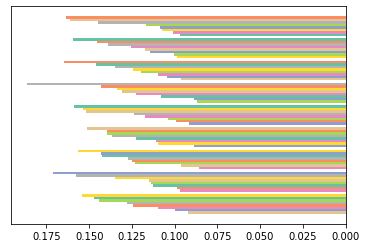

In [328]:
def make_sorted_barplot(df, labels, colors, ax=None):
    if ax is None:
        ax = plt.gca()

    x = df.values

    labels = np.asarray(labels)
    colors = np.asarray(colors)

    order = [np.where(labels == v)[0][0] for v in df.columns]


    colors = colors[order]
    labels = labels[order]

    w = 2
    n_cvs, n_grps = x.shape
    left = np.arange(n_cvs)*(n_grps+1)*2
    grp_order = np.argsort(x)[:, ::-1]

    ax = plt.gca()

    xpos = ((np.array([np.where(grp_order == i)[1] for i in np.arange(n_grps)])* w) + left).T

    for i in range(n_grps):
        ax.barh(xpos[:, i], x[:, i], w, color=colors[i], label=labels[i])


    
ax = plt.gca()

make_sorted_barplot(y_df, oc_bases_labels, oc_colors)

ax.invert_xaxis()  # labels read top-to-bottom
ax.invert_yaxis()
ax.set_yticks([])
None



# ax2 = ax.twinx()
# ax2.set_ylim(ax.get_ylim())

# ax2.set_yticks([])

# ax2.set_yticklabels([])

# np.where(grp_order == 2)[1]*w + left

In [280]:
l2 = bm_bases_labels
l2

array(['SES-related', 'PE age-related', 'PE substance-related',
       'Severe TBI', 'Mild TBI'], dtype='<U20')

In [285]:
l1 = x_df.columns
l1

Index(['Mild TBI', 'PE age-related', 'PE substance-related', 'SES-related',
       'Severe TBI'],
      dtype='object')

In [286]:
[np.where(l2 == v)[0][0] for v in l1]

[4, 1, 2, 0, 3]

In [97]:
tbifile = TrackTBIFile(ALL_CVS_PATH)
bm_weights = tbifile.cca.bm_bases
oc_weights = tbifile.cca.oc_bases
bm_weights.shape, oc_weights.shape

((235, 177), (177, 177))

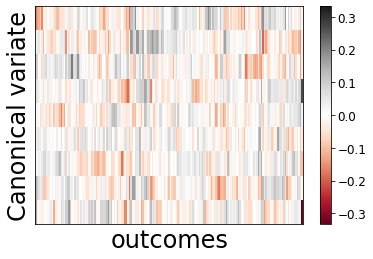

In [142]:
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, ward, leaves_list
x = oc_weights[:, :9]

cv_dmat = pdist(x.T, metric='euclidean')
feat_dmat = pdist(x, metric='euclidean')


row_linkage = ward(cv_dmat)
col_linkage = ward(feat_dmat)
kwargs = dict(
    row_linkage=row_linkage,
    col_linkage=col_linkage,
)

cv_order = leaves_list(optimal_leaf_ordering(row_linkage, cv_dmat))
feat_order = leaves_list(optimal_leaf_ordering(col_linkage, feat_dmat))


weights_heatmap_helper(x[feat_order][:, cv_order], 'outcomes', cbar=True)
plt.savefig('../../paper/cv_weights_order_cluster.png')

In [193]:
np.argsort(exp_var)[::-1][:9]

array([ 0,  2,  1, 17,  6, 48, 18,  8, 57])